In [1]:
# Import packages
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit, train_test_split

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [2]:
# Get data from my GitHub - already mostly cleaned in R (refer to contract_data.R)
df_2020 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2020_NBA_Contracts.csv',index_col = 0)
df_2021 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2021_NBA_Contracts.csv',index_col = 0)
df_2022 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2022_NBA_Contracts.csv',index_col = 0)

### Data Manipulation and Cleaning

Since the salary cap has been rising steadily, a more accurate reflection of a player's salary is the percent of the salary cap they take up

In [3]:
#Salary Cap data per nba.com
cap2020 = 109100000
cap2021 = 112414000
cap2022 = 123000000
#Add column to each DF represent player salaries as percent of salary cap
df_2020['Cap_Percent'] = df_2020['Avg_Salary']/cap2020
df_2021['Cap_Percent'] = df_2021['Avg_Salary']/cap2021
df_2022['Cap_Percent'] = df_2022['Avg_Salary']/cap2022

In [4]:
# combine last 3 years of contract data
nba_data = pd.concat([df_2020, df_2021, df_2022], ignore_index=True)

In [5]:
nba_data.describe()

,Years,Full_Salary,Avg_Salary,Age,G,GS,MP,FG,FGA,FG.,...,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP,Cap_Percent
count,313.000000,3.130000e+02,3.130000e+02,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,...,313.000000,313.000000,313.000000,313.000000,0.0,313.000000,313.000000,313.000000,313.000000,313.000000
mean,2.118211,1.816779e+07,6.268894e+06,27.166134,48.718850,18.322684,19.752077,3.068371,6.552396,0.473038,...,1.175399,1.084984,2.259105,0.096789,NaN,-0.993610,0.080192,-0.911821,0.429073,0.054899
std,1.107414,3.337870e+07,7.544011e+06,4.038818,18.627528,20.465293,7.362575,1.684789,3.601184,0.097815,...,1.385179,0.807297,1.988699,0.068273,NaN,2.836205,1.305876,3.438809,0.810440,0.065403
min,1.000000,1.445697e+06,1.445697e+06,20.000000,1.000000,0.000000,2.000000,0.000000,0.500000,0.000000,...,-1.300000,-0.100000,-0.800000,-0.365000,NaN,-16.600000,-5.500000,-22.100000,-1.500000,0.013246
25%,1.000000,2.389641e+06,1.984359e+06,24.000000,36.000000,2.000000,14.800000,1.900000,3.900000,0.415000,...,0.200000,0.400000,0.800000,0.062000,NaN,-2.400000,-0.800000,-2.300000,0.000000,0.017258
50%,2.000000,4.767000e+06,2.700000e+06,27.000000,51.000000,9.000000,19.900000,2.900000,5.900000,0.455000,...,0.700000,0.900000,1.700000,0.096000,NaN,-0.900000,0.000000,-0.900000,0.200000,0.023625
75%,3.000000,1.801926e+07,7.500000e+06,30.000000,64.000000,30.000000,24.900000,3.900000,8.200000,0.511000,...,1.900000,1.500000,3.400000,0.130000,NaN,0.300000,0.900000,0.600000,0.700000,0.065041
max,5.000000,2.510196e+08,5.020393e+07,40.000000,82.000000,80.000000,37.200000,8.900000,19.300000,1.000000,...,6.700000,4.400000,11.100000,0.475000,NaN,24.100000,7.000000,31.100000,5.400000,0.408162


In [6]:
nba_data

,Player,Years,Full_Salary,Avg_Salary,Pos,Age,Tm,G,GS,MP,...,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP,Cap_Percent
0,Alec Burks,1,6000000.0,6000000.0,SF-SG,28,TOT,66,19,26.6,...,2.5,1.2,3.7,0.101,NaN,1.2,-0.7,0.5,1.1,0.054995
1,Alex Len,1,2258000.0,2258000.0,C,26,TOT,55,12,17.6,...,1.5,1.0,2.5,0.122,NaN,-0.5,-0.3,-0.7,0.3,0.020697
2,Anthony Davis,5,189903600.0,37980720.0,PF,26,LAL,62,62,34.4,...,6.7,4.4,11.1,0.250,NaN,5.4,2.6,8.0,5.4,0.348128
3,Aron Baynes,2,14350000.0,7175000.0,C,33,PHO,42,28,22.2,...,1.3,0.8,2.1,0.107,NaN,-0.2,-0.8,-1.0,0.2,0.065765
4,Austin Rivers,3,9975000.0,3325000.0,SG,27,HOU,68,4,23.4,...,1.2,1.2,2.4,0.072,NaN,-2.1,-0.4,-2.5,-0.2,0.030477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,Tyus Jones,3,30000000.0,14500000.0,PG,25,MEM,73,23,21.2,...,3.4,1.6,5.1,0.158,NaN,1.2,0.5,1.7,1.4,0.117886
309,Victor Oladipo,4,18200000.0,9100000.0,SG,29,MIA,8,1,21.6,...,0.2,0.2,0.4,0.124,NaN,1.8,-0.5,1.3,0.1,0.073984
310,Wesley Matthews,2,2905851.0,2905851.0,SG,35,MIL,49,14,20.4,...,0.6,0.6,1.2,0.056,NaN,-3.0,-0.3,-3.3,-0.3,0.023625
311,Xavier Moon,1,1637966.0,1637966.0,SG,27,LAC,10,0,13.7,...,0.2,0.2,0.3,0.121,NaN,-1.1,1.0,-0.1,0.1,0.013317


In [7]:
#Remove columns with no data
nba_data.dropna(axis=1, how='all', inplace=True)
#Some players play multiple positions, however this creates too many different values in the Position column
#I simplified it so each player is represented by only the position they play the most
nba_data = nba_data.replace({'Pos':{'SF-SG': 'SF', 'SF-PF':'SF', 'PF-C':'PF', 'PF-SF':'PF','SG-PG':'SG','PG-SG':'PG','SG-SF':'SG','C-PF':'C'}})

In [8]:
nba_data.head()

,Player,Years,Full_Salary,Avg_Salary,Pos,Age,Tm,G,GS,MP,...,USG.,OWS,DWS,WS,WS.48,OBPM,DBPM,BPM,VORP,Cap_Percent
0,Alec Burks,1,6000000.0,6000000.0,SF,28,TOT,66,19,26.6,...,23.8,2.5,1.2,3.7,0.101,1.2,-0.7,0.5,1.1,0.054995
1,Alex Len,1,2258000.0,2258000.0,C,26,TOT,55,12,17.6,...,18.1,1.5,1.0,2.5,0.122,-0.5,-0.3,-0.7,0.3,0.020697
2,Anthony Davis,5,189903600.0,37980720.0,PF,26,LAL,62,62,34.4,...,29.3,6.7,4.4,11.1,0.250,5.4,2.6,8.0,5.4,0.348128
3,Aron Baynes,2,14350000.0,7175000.0,C,33,PHO,42,28,22.2,...,21.1,1.3,0.8,2.1,0.107,-0.2,-0.8,-1.0,0.2,0.065765
4,Austin Rivers,3,9975000.0,3325000.0,SG,27,HOU,68,4,23.4,...,15.6,1.2,1.2,2.4,0.072,-2.1,-0.4,-2.5,-0.2,0.030477


In [9]:
nba_data.iloc[:,:20].describe()

,Years,Full_Salary,Avg_Salary,Age,G,GS,MP,FG,FGA,FG.,X3P,X3PA,X3P.,X2P,X2PA,X2P.,eFG.
count,313.000000,3.130000e+02,3.130000e+02,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,304.000000,313.000000,313.000000,313.000000,313.000000
mean,2.118211,1.816779e+07,6.268894e+06,27.166134,48.718850,18.322684,19.752077,3.068371,6.552396,0.473038,0.945687,2.600958,0.333204,2.120767,3.956230,0.535147,0.542048
std,1.107414,3.337870e+07,7.544011e+06,4.038818,18.627528,20.465293,7.362575,1.684789,3.601184,0.097815,0.804149,2.051039,0.122667,1.428258,2.598021,0.100778,0.085630
min,1.000000,1.445697e+06,1.445697e+06,20.000000,1.000000,0.000000,2.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
25%,1.000000,2.389641e+06,1.984359e+06,24.000000,36.000000,2.000000,14.800000,1.900000,3.900000,0.415000,0.300000,0.800000,0.292750,1.100000,2.000000,0.478000,0.502000
50%,2.000000,4.767000e+06,2.700000e+06,27.000000,51.000000,9.000000,19.900000,2.900000,5.900000,0.455000,0.800000,2.300000,0.347000,1.900000,3.400000,0.533000,0.542000
75%,3.000000,1.801926e+07,7.500000e+06,30.000000,64.000000,30.000000,24.900000,3.900000,8.200000,0.511000,1.400000,3.800000,0.390250,2.900000,5.200000,0.591000,0.580000
max,5.000000,2.510196e+08,5.020393e+07,40.000000,82.000000,80.000000,37.200000,8.900000,19.300000,1.000000,3.500000,8.700000,1.000000,7.700000,14.200000,1.000000,1.000000


In [10]:
nba_data.iloc[:,20:40].describe()

,FT,FTA,FT.,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS.,X3PAr,FTr,ORB.,DRB.,TRB.,AST.
count,313.000000,313.000000,308.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,1.183067,1.555272,0.750935,0.886901,2.838658,3.724601,1.767412,0.617252,0.411182,0.977316,1.715974,8.265495,13.705431,0.569045,0.388470,0.244821,5.245367,15.941534,10.611821,12.176997
std,1.023162,1.227351,0.123602,0.748024,1.501583,2.093167,1.496350,0.353584,0.382765,0.578595,0.641113,4.690787,5.183301,0.076263,0.224021,0.144889,4.157229,6.456725,4.912767,7.489787
min,0.000000,0.000000,0.333000,0.000000,0.300000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,-10.800000,0.111000,0.000000,0.000000,0.000000,3.900000,2.900000,0.000000
25%,0.500000,0.700000,0.686000,0.400000,1.800000,2.300000,0.800000,0.400000,0.100000,0.600000,1.300000,5.000000,10.900000,0.535000,0.239000,0.145000,2.000000,11.200000,6.800000,7.200000
50%,1.000000,1.300000,0.769000,0.600000,2.600000,3.400000,1.400000,0.600000,0.300000,0.900000,1.700000,7.400000,13.300000,0.570000,0.417000,0.222000,3.600000,14.400000,9.500000,9.700000
75%,1.500000,2.000000,0.833000,1.100000,3.600000,4.700000,2.100000,0.800000,0.600000,1.200000,2.200000,10.600000,16.600000,0.607000,0.545000,0.313000,7.700000,19.700000,13.600000,15.100000
max,7.200000,8.500000,1.000000,4.100000,9.700000,13.500000,10.300000,2.000000,2.900000,4.400000,3.500000,26.100000,54.600000,1.000000,0.889000,1.000000,18.000000,37.500000,26.700000,40.900000


In [11]:
nba_data.iloc[:,40:60].describe()

,STL.,BLK.,TOV.,USG.,OWS,DWS,WS,WS.48,OBPM,DBPM,BPM,VORP,Cap_Percent
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,1.485942,1.971885,12.271246,17.439936,1.175399,1.084984,2.259105,0.096789,-0.993610,0.080192,-0.911821,0.429073,0.054899
std,0.664093,1.821676,4.560906,4.450731,1.385179,0.807297,1.988699,0.068273,2.836205,1.305876,3.438809,0.810440,0.065403
min,0.000000,0.000000,0.000000,6.900000,-1.300000,-0.100000,-0.800000,-0.365000,-16.600000,-5.500000,-22.100000,-1.500000,0.013246
25%,1.100000,0.700000,9.300000,14.000000,0.200000,0.400000,0.800000,0.062000,-2.400000,-0.800000,-2.300000,0.000000,0.017258
50%,1.400000,1.400000,11.900000,17.200000,0.700000,0.900000,1.700000,0.096000,-0.900000,0.000000,-0.900000,0.200000,0.023625
75%,1.900000,2.600000,14.500000,20.400000,1.900000,1.500000,3.400000,0.130000,0.300000,0.900000,0.600000,0.700000,0.065041
max,3.800000,13.700000,34.200000,30.800000,6.700000,4.400000,11.100000,0.475000,24.100000,7.000000,31.100000,5.400000,0.408162


Although all values are within expected values most data appears to be heavily skewed

In [12]:
nba_data.isna().sum()

Player         0
Years          0
Full_Salary    0
Avg_Salary     0
Pos            0
Age            0
Tm             0
G              0
GS             0
MP             0
FG             0
FGA            0
FG.            0
X3P            0
X3PA           0
X3P.           9
X2P            0
X2PA           0
X2P.           0
eFG.           0
FT             0
FTA            0
FT.            5
ORB            0
DRB            0
TRB            0
AST            0
STL            0
BLK            0
TOV            0
PF             0
PTS            0
PER            0
TS.            0
X3PAr          0
FTr            0
ORB.           0
DRB.           0
TRB.           0
AST.           0
STL.           0
BLK.           0
TOV.           0
USG.           0
OWS            0
DWS            0
WS             0
WS.48          0
OBPM           0
DBPM           0
BPM            0
VORP           0
Cap_Percent    0
dtype: int64

In [13]:
# Since FT percent and 3 point percent are the only column with NAs, it may be from the player having 0 attempts 
nba_data[nba_data['FT.'].isna()]['FTA']

92     0.0
128    0.0
222    0.0
231    0.0
301    0.0
Name: FTA, dtype: float64

In [14]:
nba_data[nba_data['X3P.'].isna()]['X3PA']

6      0.0
38     0.0
217    0.0
231    0.0
241    0.0
257    0.0
272    0.0
289    0.0
290    0.0
Name: X3PA, dtype: float64

In [15]:
# The NAs will be filled with 0 as they represent players who never made or attempted a free throw
nba_data = nba_data.fillna(0)

In [16]:
nba_data.isna().sum() # re run to ensure no more NAs

Player         0
Years          0
Full_Salary    0
Avg_Salary     0
Pos            0
Age            0
Tm             0
G              0
GS             0
MP             0
FG             0
FGA            0
FG.            0
X3P            0
X3PA           0
X3P.           0
X2P            0
X2PA           0
X2P.           0
eFG.           0
FT             0
FTA            0
FT.            0
ORB            0
DRB            0
TRB            0
AST            0
STL            0
BLK            0
TOV            0
PF             0
PTS            0
PER            0
TS.            0
X3PAr          0
FTr            0
ORB.           0
DRB.           0
TRB.           0
AST.           0
STL.           0
BLK.           0
TOV.           0
USG.           0
OWS            0
DWS            0
WS             0
WS.48          0
OBPM           0
DBPM           0
BPM            0
VORP           0
Cap_Percent    0
dtype: int64

### Data Transformations

In [17]:
#view all columns
nba_data.columns

Index(['Player', 'Years', 'Full_Salary', 'Avg_Salary', 'Pos', 'Age', 'Tm', 'G',
       'GS', 'MP', 'FG', 'FGA', 'FG.', 'X3P', 'X3PA', 'X3P.', 'X2P', 'X2PA',
       'X2P.', 'eFG.', 'FT', 'FTA', 'FT.', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS.', 'X3PAr', 'FTr', 'ORB.', 'DRB.',
       'TRB.', 'AST.', 'STL.', 'BLK.', 'TOV.', 'USG.', 'OWS', 'DWS', 'WS',
       'WS.48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Cap_Percent'],
      dtype='object')

In [18]:
# Drop columns that are unusable as predictive features
nba_data = nba_data.drop(['Player', 'Years', 'Full_Salary', 'Avg_Salary','Tm'], axis =1)
# Split the rest into categorical and numeric features
cat_features = ["Pos"]
num_features = ['Age', 'G',
                'GS', 'MP', 'FG', 'FGA', 'FG.', 'X3P', 'X3PA', 'X3P.', 'X2P', 'X2PA',
                'X2P.', 'eFG.', 'FT', 'FTA', 'FT.', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
                'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS.', 'X3PAr', 'FTr', 'ORB.', 'DRB.',
                'TRB.', 'AST.', 'STL.', 'BLK.', 'TOV.', 'USG.', 'OWS', 'DWS', 'WS',
                'WS.48', 'OBPM', 'DBPM', 'BPM', 'VORP']

In [19]:
X = nba_data
y = X.pop('Cap_Percent')
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

In [21]:
# since sum features have 0 yeo-johnson transformation will be used rather than logarithmic or box-cox
pt1 = PowerTransformer(method='yeo-johnson')
X_train_transformed1 = pt1.fit_transform(X_train[num_features])
X_train_transformed1 = pd.DataFrame(X_train_transformed1 , columns = X_train[num_features].columns)

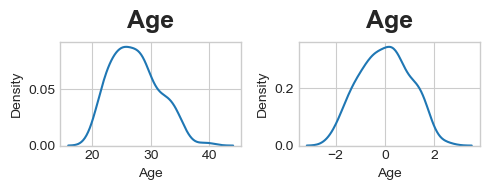

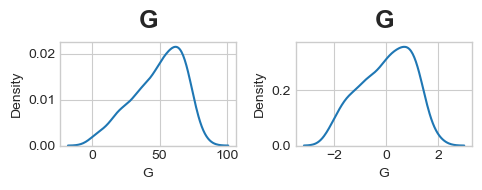

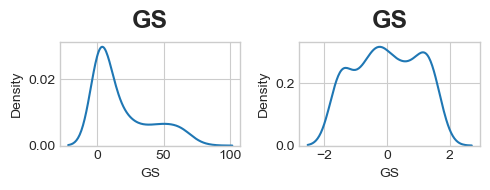

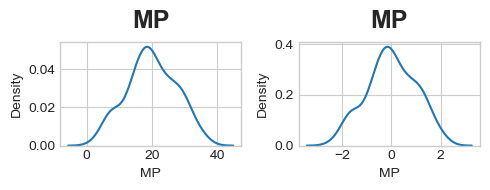

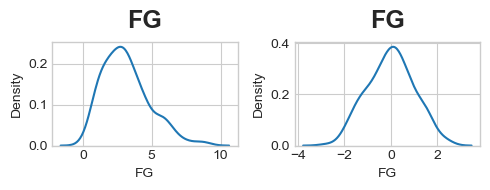

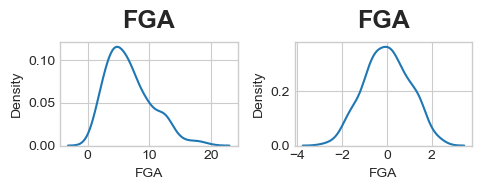

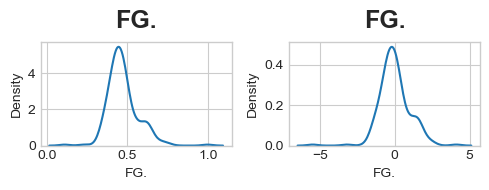

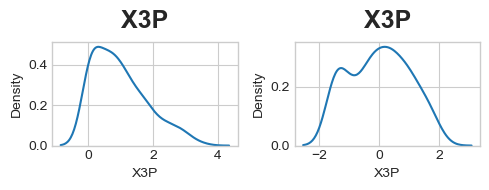

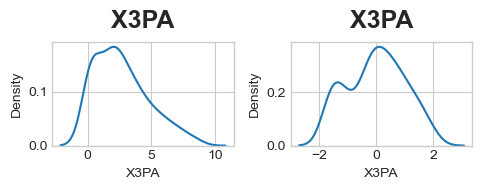

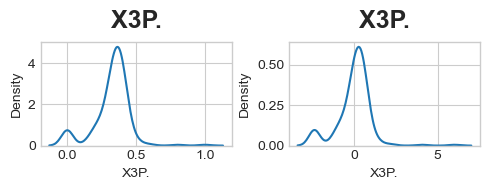

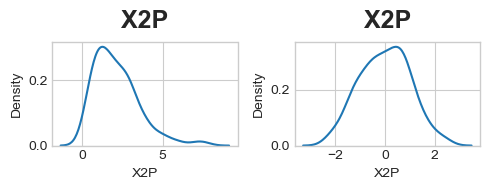

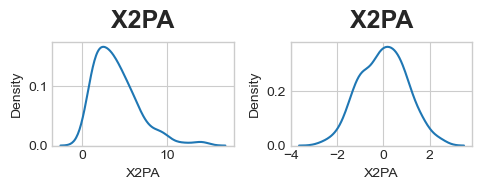

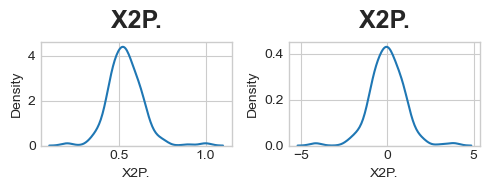

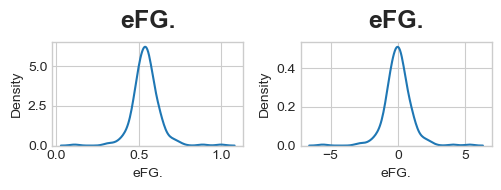

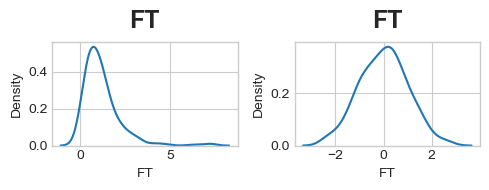

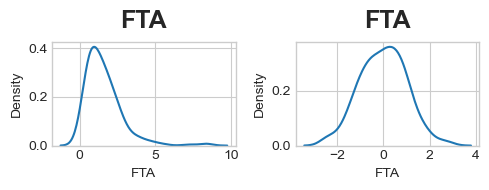

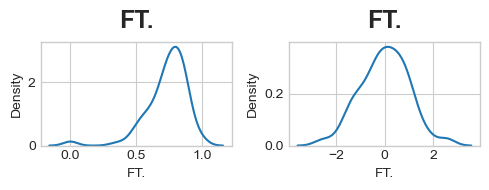

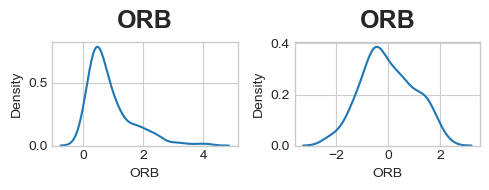

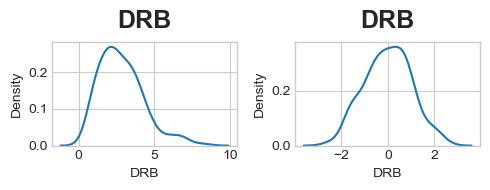

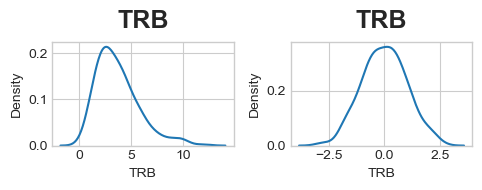

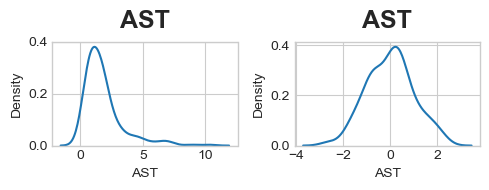

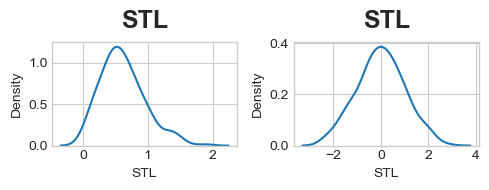

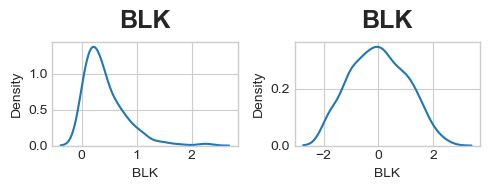

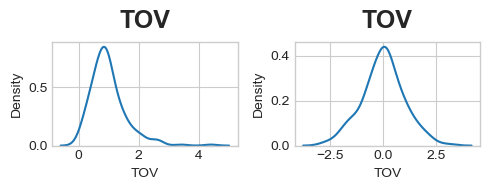

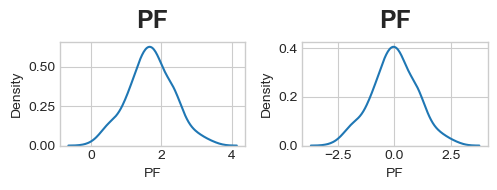

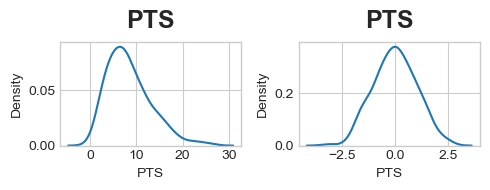

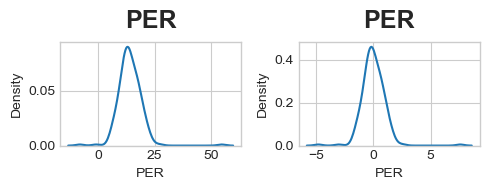

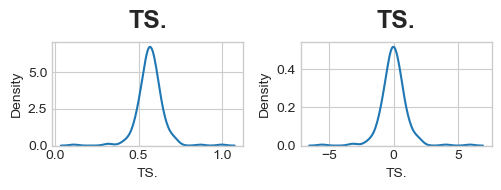

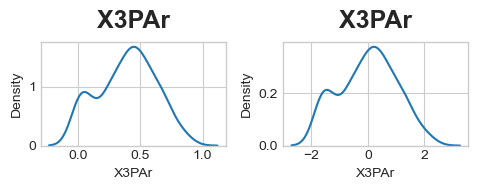

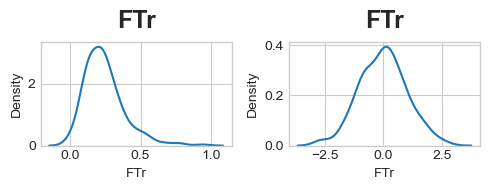

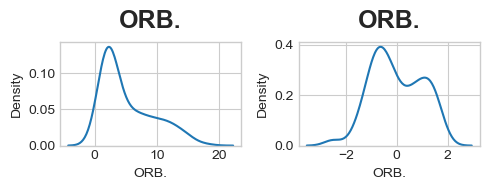

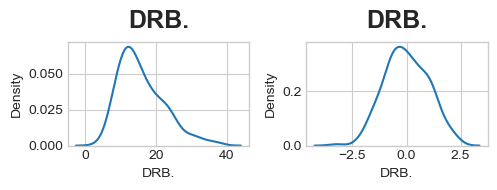

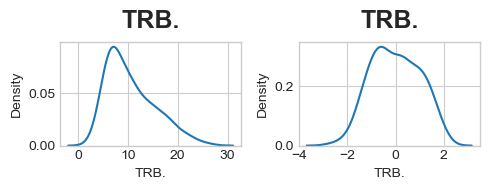

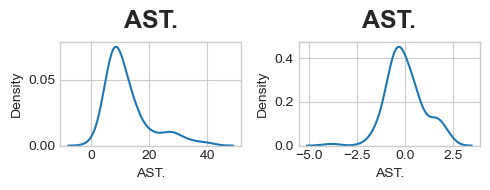

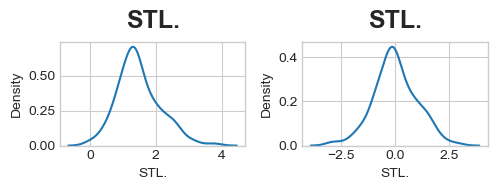

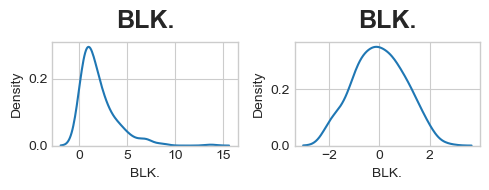

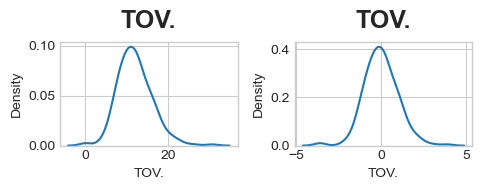

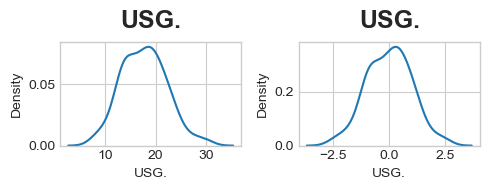

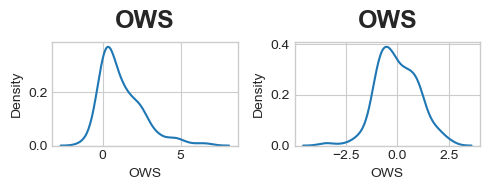

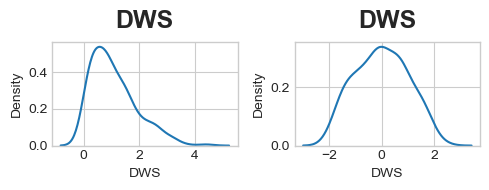

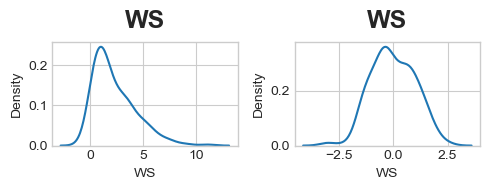

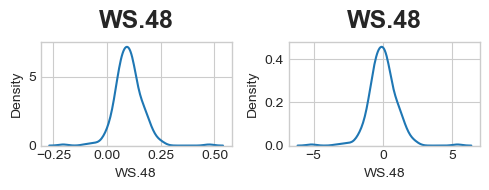

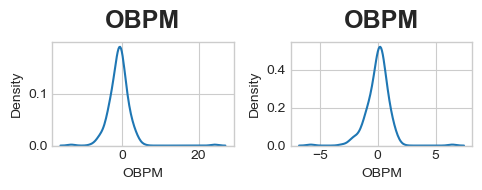

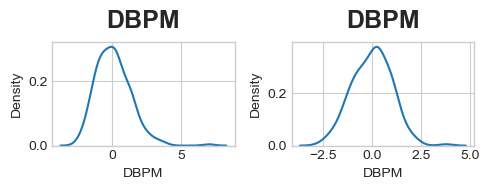

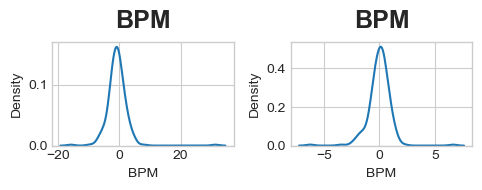

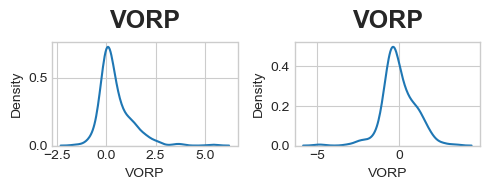

In [22]:
# View Skewdness of numeric data
for col in num_features:
    plt.figure(figsize=(5,2))
    plt.subplot(121)
    sns.kdeplot(X_train[col])
    plt.title(col)
    
    plt.subplot(122)
    sns.kdeplot(X_train_transformed1[col])
    plt.title(col)
    
    plt.show()

In [26]:
# Since all y values are positive box-cox can be used
pt2 = PowerTransformer(method='box-cox')
y_train_transformed = pt2.fit_transform(y_train.to_frame())

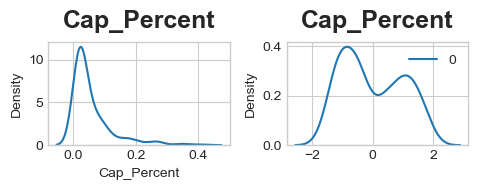

In [27]:
# View Skewdness of numeric data

plt.figure(figsize=(5,2))
plt.subplot(121)
sns.kdeplot(y_train)
plt.title('Cap_Percent')
    
plt.subplot(122)
sns.kdeplot(y_train_transformed)
plt.title('Cap_Percent')

plt.show()

In [28]:
# Define preprocessor
preprocessor = make_column_transformer(
    (PowerTransformer(method='yeo-johnson'), num_features),
    (OneHotEncoder(), cat_features)
)
bc_transformer = PowerTransformer(method='box-cox')

In [29]:
# Apply transformations on all data sets
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Since all values in y are positive box-cox transformation can be applied
y_train = bc_transformer.fit_transform(y_train.to_frame())
y_test = bc_transformer.transform(y_test.to_frame())

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [51]


In [30]:
model = LinearRegression()
model.fit(X_train, y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.8120475219655734


In [31]:
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth, random_state = 0)
    model.fit(X_train, y_train)

    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)

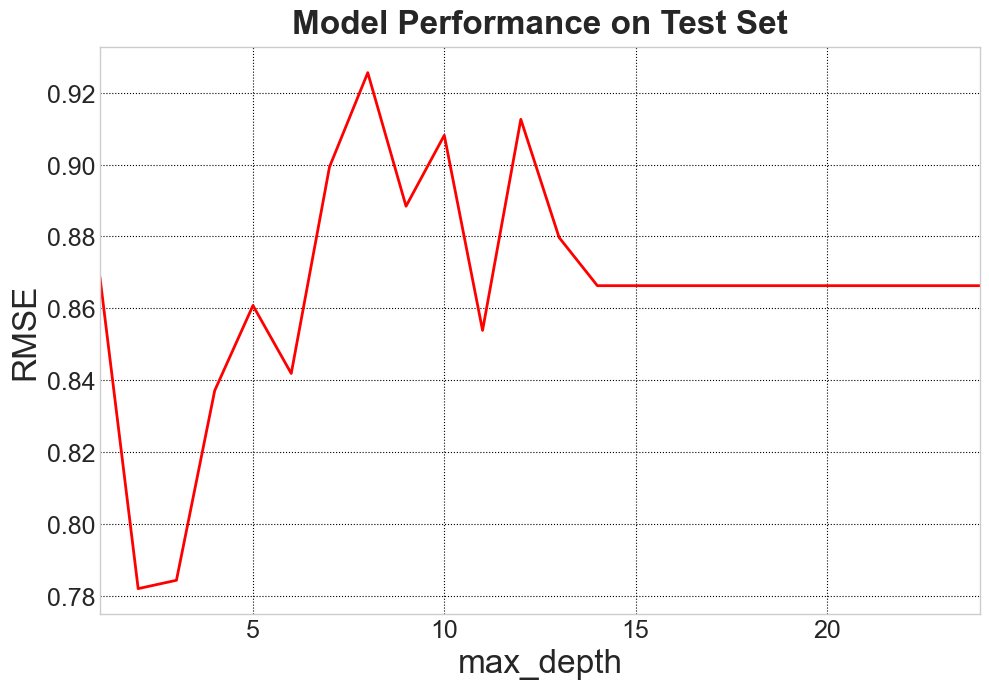

In [32]:
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (10,7),
                       facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [33]:
depth = 2
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.7820902447491201


In [34]:
model = xgb.XGBRegressor(objective ='reg:squarederror',
                         n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.6894945266740625


In [35]:
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = Ridge(alpha = depth, random_state = 0)
    model.fit(X_train, y_train)

    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)

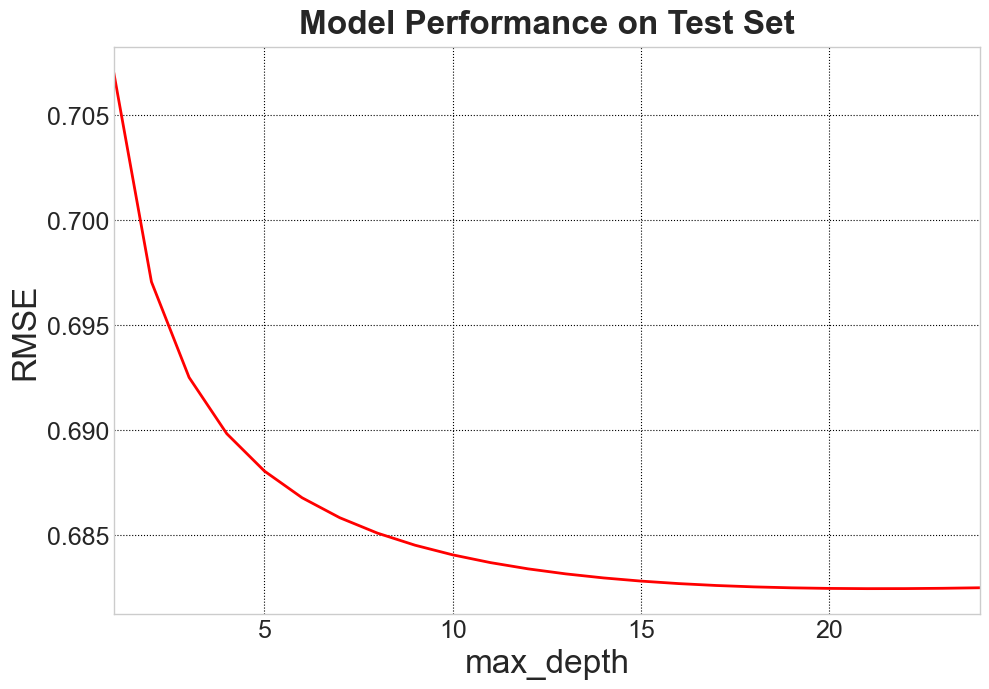

In [36]:
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (10,7),
                       facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [37]:
model = Ridge(alpha=20)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.6824546496130046


In [ ]:
# Ridge regression performs best

In [39]:
# inverse transform for interpretability
predicted_scaled_bc = bc_transformer.inverse_transform(y_predicted.reshape(-1,1))
predicted_scaled = bc_transformer.inverse_transform(y_test.reshape(-1,1))
mean_squared_error(predicted_scaled, predicted_scaled_bc, squared=True)

C:\Users\kthay\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\kthay\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


0.004925192654243975